# `XGBoost` in Python from Start to Finish

https://www.youtube.com/watch?v=GrJP9FLV3FE&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&index=5&ab_channel=StatQuestwithJoshStarmer, 27 September 2021

In this lesson we will use `XGBoost` to predict on IBM's [Telco Churn dataset](https://community.ibm.com/accelerators/catalog/content/Telco-customer-churn) whether or not a customer will stop using a company's service. In the world of business this is called **Customer Churn**.

`XGBoost` is an exceptionally useful machine learning method when you don't want to sacrifice the ability to correctly classify observations, but you still want a model that is fairly easy to understand and interpret.

Contents:
* [Importing Data from File](#chapter1)
* [Missing Data](#chapter2)
    - Identifying Missing Data
    - Dealing with Missing Data
* [Formatting the Data for `XGBoost`](#chapter3)
    - Splitting Data into Dependent and Independent Variables
    - One-Hot Encoding
    - Converting all Columns to Int, Float, or Bool
* [Building a Preliminary `XGBoost` model](#chapter4)
* [Optimizing Parameters with Cross-Validation and `GridSearchCV()`](#chapter5)
    - Optimizing the learning rate, tree depth, number of trees, gamma (for pruning), and lambda (for regularization).
* [Building, Drawing, Interpreting, and Evaluating the Optimized `XGBoost` model](#chapter6)

---

# Import the modules that will do all the work

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from time import time

# Import the Data <a class='anchor' id='chapter1'></a>

In [2]:
df = pd.read_excel('Telco_customer_churn.xlsx')

In [3]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


**NOTE:** The last four features are exit interview information, i.e, data that the customer provided after they left the company, and only people that left have provided answers here. These features will give us perfect predictive ability, so we will remove them from the data set.

In [4]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'],
        axis=1, #axis=1 for columns
        inplace=True) #inplace=True to directly change the dataframe, w/out returned value
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


**NOTE:** Some columns contain a single value, and will not be useful for prediction.

In [5]:
df['Count'].unique()

array([1], dtype=int64)

In [6]:
df['Country'].unique()

array(['United States'], dtype=object)

In [7]:
df['State'].unique()

array(['California'], dtype=object)

**NOTE:** `CustomerID` is different for evey user, so it is useless for classification. `Lat Long` is not necessary because there are separate columns for `Latitutde` and `Longitude`.

In [8]:
df.drop(['Count', 'Country', 'State', 'CustomerID', 'Lat Long'], axis=1, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


# Missing Data Part 1: Identifying Missing Data <a class='anchor' id='chapter2'></a>

In [9]:
df.dtypes

City                  object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
dtype: object

**NOTE:** The feature `Total Charges` seems like it contains numerical data, but the `object` datatype suggests it is a categorical feature.

In [10]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'])

ValueError: Unable to parse string " " at position 2234

**NOTE:** When we run the line in the cell above we get the error `ValueError: Unable to parse string " " at position 2234`, so we conclude that there is blank space `" "` in the data that needs to be handled.

# Missing Data Part 2: Dealing with Missing Data `XGBoost` Style

**NOTE:** One thing that is relatively unique to `XGBoost` is that it has default behaviour for handling missing data. All we have to do is identify missing data points and make sure they are set to `0`.

If there are a lot of rows with missing data, then we might have a bigger problem than what `XGBoost` can deal with on its own. If it's not that many, we can just set them to `0`.

In [11]:
df.loc[df['Total Charges'] == ' '].shape[0]

11

In [12]:
df.loc[df['Total Charges'] == ' ']

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,San Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


**NOTE:** We can see that for those that don't have a value for `Total Charge`, for the column `Tenure Months` have a value of zero, meaning that they have just subscribed to the service so they haven't been charged yet.

Also, these clients all have `Churn Value` set to `0` because they have just signed up.

So, we have two options to choose from:
- we can set `Total Charges` to `0` for these people, or
- we can remove them.
In this example, we will choose the first option.

In [13]:
df.loc[df['Total Charges'] == ' ', 'Total Charges'] = '0' #Updating value with .loc

In [14]:
df.loc[df['Total Charges'] == '0']

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,San Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


**NOTE:** `XGBoost` allows only `int`, `float`, and `bool` data types. Because `Total Charges` is `object` data type, now we can convert the values from categorical to numerical.

In [15]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'])
df.dtypes

City                  object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
dtype: object

**NOTE:** In order to draw the tree with the graph visualization software Graphviz, we need to replace every white space in all the columns and column names with underscores `_`. This is not required by `XGBoost`, only by Graphviz. If we don't intend to use this software, we can skip this step in our other projects.

In [16]:
df.replace(' ', '_', regex=True, inplace=True)
df.columns = df.columns.str.replace(' ', '_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


# Format Data Part 1: Splitting Data into Dependent and Independent Variables <a class='anchor' id='chapter3'></a>

**NOTE:** In this case, we want to predict `Churn Value` (whether or not someone will leave the company or not).

In [17]:
X = df.drop('Churn_Value', axis=1).copy(deep=True)
y = df['Churn_Value'].copy(deep=True)

# Format Data Part 2: One-Hot Encoding

**NOTE:** It may seem that converting the categorial data to numerical is a reasonable thing to do. But this is wrong. Here's why. Let's take the feature `Payment_Method` which has the following options:
1. `Mailed_Check`,
2. `Electronic_Check`,
3. `Bank_Transfer`,
4. `Credit_Card`.

If we converted these categories to numbers 1, 2, 3, and 4, and treated them like numerical data, then we would assume that 4, which means `Credit_Card`, is more similar to 3, which means `Bank_Transfer`, than it is to 1 or 2, which are other forms of payment. That means the `XGBoost` trees would be more likely to cluster the people with 3s and 4s together, than the people with 4s and 1s together.

**ANOTHER NOTE:** If we treat `Payment_Method` like categorical data, then we treat each value as a separate category that is no more or less similar to any of the other category. This is done with the technique called **one-hot encoding**. There are many different ways to do this in Python, but the following are the most popular: `ColumnTransformer()` (from `scikit-learn`), and `get_dummies()` (from `pandas`), and both methods have pros and cons.

`ColumnTransformer()` has a feature where it creates a persistent funcition that can validate data that you get in the future. The `ColumnTransformer()` can remember the options of the categorical feature, and when the `XGBoost` model (or any other model) is deployed in production it can recongize if someone records incorrect data point, and can throw an error, or handle the situation in a different way. The con of `ColumnTransformer()` is that it converts all data to an array, and looses the colun names, which might make it harder to verify the results.

On the other hand, `get_dummies()` leaves the data in a dataframe and retains the column names, making it much easier to verify that it worked the way that it was intended. However, it doesn't have the behaviour as `ColumnTransformer()` has.

In this example, we will use `get_dummies()` for the sake of learning.

In [18]:
X_encoded = pd.get_dummies(X, X.loc[:, df.dtypes == 'object'].columns)
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


In [19]:
y.unique()

array([1, 0], dtype=int64)

**NOTE:** `XGBoost` uses **sprase matrices** and it only alocates memory for the 1s. Hence, it is memory efficient while it deals with missing data.

# Build a Preliminary XGBoost Model <a class='anchor' id='chapter4'></a>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=0, stratify=y)

In [21]:
t0 = time()
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', #XGBoost uses logistic regression for classifying binary data
                            missing=None, #Uses 0s for missing data, so it doesn't have to allocate data
                            seed=42,
                            use_label_encoder=False
                           )
clf_xgb.fit(X_train,
            y_train,
            verbose=True, #to tell us what it is doing
            early_stopping_rounds=10,
            eval_metric='aucpr', #AUC metric to evaluate prediction
            eval_set=[(X_test, y_test)] #pass test dataset to evaluate performance how well the model generalizes to unseen data
           )
training_time = time() - t0
print(f'{training_time} s')

[0]	validation_0-aucpr:0.62420
[1]	validation_0-aucpr:0.64815
[2]	validation_0-aucpr:0.65681
[3]	validation_0-aucpr:0.65690
[4]	validation_0-aucpr:0.65703
[5]	validation_0-aucpr:0.65575
[6]	validation_0-aucpr:0.65855
[7]	validation_0-aucpr:0.65349
[8]	validation_0-aucpr:0.66014
[9]	validation_0-aucpr:0.66052
[10]	validation_0-aucpr:0.66508
[11]	validation_0-aucpr:0.66646
[12]	validation_0-aucpr:0.66680
[13]	validation_0-aucpr:0.66739
[14]	validation_0-aucpr:0.66620
[15]	validation_0-aucpr:0.66241
[16]	validation_0-aucpr:0.66380
[17]	validation_0-aucpr:0.66322
[18]	validation_0-aucpr:0.66335
[19]	validation_0-aucpr:0.66424
[20]	validation_0-aucpr:0.66479
[21]	validation_0-aucpr:0.66513
[22]	validation_0-aucpr:0.66236
[23]	validation_0-aucpr:0.66038
1.8786756992340088 s


**NOTE:** We are using **early stopping** to stop building trees when they no longer improve the prediction. What this is that, we are building trees, and at some point the prediction will not improve. The parameter `early_stopping_rounds` set to 10 is gonna tell `XGBoost` to build ten more trees, and if none of those ten trees can further improve the prediction, it will stop.

In [22]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Did not leave', 'Left']
                     )
plt.show()

XGBoostError: [20:54:39] c:\users\administrator\workspace\xgboost-win64_release_1.4.0\src\c_api\c_api_utils.h:161: Invalid missing value: null

**NOTE:** Because the data is imbalanced, `XGBoost` didn't perform satisfactorily. To correct this issue, `XGBoost` has a parameter `scale_pos_weight` that helps with imbalanced data.

# Optimize Parameters with Cross Validation and `GridSearchCV()` <a class='anchor' id='chapter5'></a>

**NOTE:** When the data is imbalanced, in the `XGBoost` manual they suggest we:
- balance the data with the hyper-parameter `scale_pos_weight`,
- use AUC metric for evaluation.

**ANOTHER NOTE:** In order to speedup the cross-validation, and to further prevent overfitting, we are only using random subset of the data (90% in this example), and are only using random subset of the features (50% in this example).

In [23]:
param_grid = {'max_depth': [3, 4, 5],
              'learning_rate': [0.1, 0.5, 1],
              'gamma': [0, 0.25, 1],
              'reg_lambda': [10, 20, 100],
              'scale_pos_weight': [1, 3, 5] #XGBoost recommends: sum(negative instances) / sum(positive instances)
             }

optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic',
                                                missing=None,
                                                seed=42,
                                                use_label_encoder=False,
                                                subsample=0.9,
                                                colsample_bytree=0.5),
                              param_grid=param_grid,
                              scoring='roc_auc',
                              verbose=0,
                              n_jobs=-1,
                              cv=3)
t0 = time()
optimal_params.fit(X_train,
                   y_train,
                   verbose=True,
                   early_stopping_rounds=10,
                   eval_metric='aucpr',
                   eval_set=[(X_test, y_test)]
                  )

grid_searching_time = time() - t0
print(f'Grid searching time: {grid_searching_time} s')

print(optimal_params.best_params_)

KeyboardInterrupt: 

# Building, Drawing, Interpreting, and Evaluating the Optimized `XGBoost` model <a class='anchor' id='chapter6'></a>

In [24]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            missing=None,
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=10,
                            scale_pos_weight=1,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            seed=42,
                            use_label_encoder=False
                           )
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)]
           )

[0]	validation_0-aucpr:0.55073
[1]	validation_0-aucpr:0.60452
[2]	validation_0-aucpr:0.62129
[3]	validation_0-aucpr:0.62656
[4]	validation_0-aucpr:0.62759
[5]	validation_0-aucpr:0.62929
[6]	validation_0-aucpr:0.62788
[7]	validation_0-aucpr:0.63415
[8]	validation_0-aucpr:0.63944
[9]	validation_0-aucpr:0.63983
[10]	validation_0-aucpr:0.63762
[11]	validation_0-aucpr:0.63730
[12]	validation_0-aucpr:0.63643
[13]	validation_0-aucpr:0.64013
[14]	validation_0-aucpr:0.64038
[15]	validation_0-aucpr:0.64643
[16]	validation_0-aucpr:0.65095
[17]	validation_0-aucpr:0.65113
[18]	validation_0-aucpr:0.65235
[19]	validation_0-aucpr:0.65166
[20]	validation_0-aucpr:0.65533
[21]	validation_0-aucpr:0.65422
[22]	validation_0-aucpr:0.65437
[23]	validation_0-aucpr:0.65552
[24]	validation_0-aucpr:0.65619
[25]	validation_0-aucpr:0.65631
[26]	validation_0-aucpr:0.65701
[27]	validation_0-aucpr:0.65821
[28]	validation_0-aucpr:0.65877
[29]	validation_0-aucpr:0.65979
[30]	validation_0-aucpr:0.65957
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Did not leave', 'Left']
                     )
plt.show()

**NOTE:** We are doing much better job at classifying people that left the company, but this is at the expense of not being able to correctly classify as many people that didn't leave the company.

**NOTE (HIS INTERPRETATION):** When people leave the company, they reduce the revenue of the company as well. It would seem more reasonable to catch those people before they leave, and try to manipulate them to continue to use the services of the company.

In [ ]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            missing=None,
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=10,
                            scale_pos_weight=1,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            seed=42,
                            use_label_encoder=False,
                            n_estimators=1 #We want to draw the first tree
                           )
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)]
           )

**NOTE:** Printing the first tree might give as educated guess for the hyper-parameters.

**ANOTHER NOTE:** we only built one tree, so `gain` = `total_gain`, and `cover` = `total_cover`.

weight:  {'Tech_Support_No': 11, 'Tenure_Months': 55, 'Monthly_Charges': 50, 'Internet_Service_Fiber_optic': 13, 'Internet_Service_DSL': 3, 'Payment_Method_Electronic_check': 12, 'City_Palm_Desert': 1, 'Contract_Month-to-month': 17, 'City_Whittier': 2, 'Online_Security_No': 12, 'Dependents_No': 27, 'City_Santa_Ana': 2, 'City_Pomona': 1, 'City_San_Bernardino': 1, 'Contract_Two_year': 13, 'Dependents_Yes': 12, 'Zip_Code': 32, 'City_Santa_Barbara': 1, 'Total_Charges': 41, 'City_Rancho_Cucamonga': 1, 'Longitude': 20, 'Senior_Citizen_No': 6, 'Partner_No': 6, 'Tech_Support_Yes': 3, 'Streaming_Movies_Yes': 7, 'Paperless_Billing_No': 8, 'Latitude': 21, 'Streaming_Movies_No': 3, 'Device_Protection_No': 1, 'Online_Backup_No': 9, 'Multiple_Lines_No': 7, 'Paperless_Billing_Yes': 6, 'City_Sacramento': 2, 'City_Fresno': 1, 'Phone_Service_Yes': 2, 'City_San_Diego': 3, 'Internet_Service_No': 4, 'Contract_One_year': 2, 'Gender_Female': 4, 'Senior_Citizen_Yes': 1, 'City_Bakersfield': 1, 'Multiple_Lines_

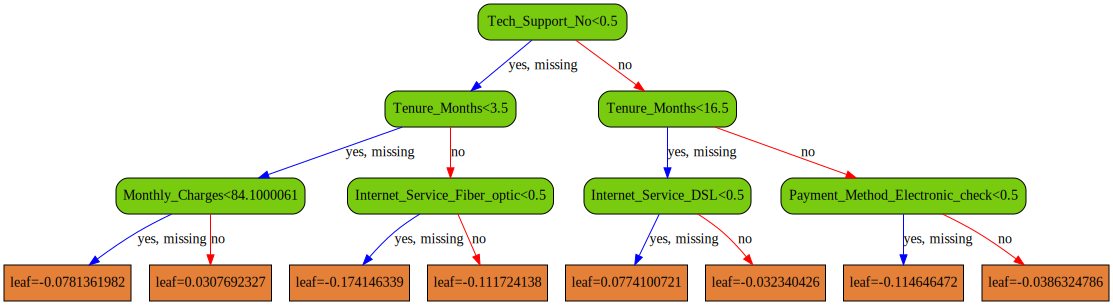

In [25]:
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'
              }
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'
              }

xgb.to_graphviz(clf_xgb, num_trees=0, size='10,10', condition_node_params=node_params, leaf_node_params=leaf_params)